## Analyze A/B Test Results

### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

The aim of this project is to perform and understand the results of an A/B test run by an e-commerce website to make a recommendation on whether they should implement the new webpage, keep the old webpage, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

First, the observed proportions and probabilities from the data set are considered.

#### Dataset exploration

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
# Reading in the main dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

In [4]:
# Checking for missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

All the people in the treatment group were assigned the new version of the page while the control group had the old page. In order to determine if there are any mistakes in the data, I search for the records where **new_page** and **treatment** don't match.

In [5]:
(df.query("landing_page == 'new_page' & group != 'treatment'").user_id.count() 
 + df.query("group == 'treatment' & landing_page != 'new_page'").user_id.count())

3893

For the rows where **treatment** does not match with **new_page** or **control** does not correspond with **old_page**, we cannot be sure if this row truly received the new or old page. Therefore, these records should be removed.

In [6]:
to_drop = (
    df.query("landing_page == 'new_page' & group != 'treatment'").index.tolist() 
    + df.query("group == 'treatment' & landing_page != 'new_page'").index.tolist())

In [7]:
# Checking that lengths match
len(to_drop)

3893

A new database **df2** is created to only contain the valid records.

In [8]:
df2 = df.drop(to_drop, axis=0)
df2.shape

(290585, 5)

In [9]:
# Checking that all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
# Checking for duplicates in the df2
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [11]:
# Removing the duplicate
df2.drop(df2[df2.user_id.duplicated()].index, axis=0, inplace=True)
df2.shape

(290584, 5)

----
#### Probabilities

The probability of an individual converting regardless of the page they receive:

In [12]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the **control group**, the probability they converted:

In [13]:
df2.query("group == 'control'").converted.mean()

0.1203863045004612

Given that an individual was in the **treatment group**, the probability they converted:

In [14]:
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

The probability that an individual received the new page

In [15]:
df2.query("landing_page == 'new_page'").user_id.count()/df2.shape[0]

0.5000619442226688

#### Part l - Conclusion

As can be seen from the cells above, the probability of an individual converting regardless of the page they receive is around 11.96%. The probability of conversion for the treatment group is 11.88% and is almost the same as for the control group which is 12%. Therefore, superficially it could be argued that the new treatment page does not lead to more conversions. This also means that the difference will likely not be practically significant.

<a id='ab_test'></a>
### Part II - A/B Test

Due to the time stamp associated with each event, technically, it is possible to run a hypothesis test continuously as each observation was observed.  

However, then the hard question is whether to stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long does the test needs to run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

Therefore a decision will be made based on all the data provided.  It is assumed that the old page is better unless the new page proves to be definitely better considering Type I error rate (alpha) of 5%. 

*Therefore the null and the alternative hypotheses are as follows:*
$$H_0: p_{new} - p_{old} \le 0 $$
$$H_1: p_{new} - p_{old} > 0$$

*or*
$$H_0: p_{new} \le p_{old}$$
$$H_1: p_{new} > p_{old}$$

The hypotheses are stated in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Simulating the distribution under the null 

It is assumed that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of the page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, it is assumed that they are equal to the **converted** rate in **ab_data.csv** regardless of the page. 

The sample size for each page will be equal to the ones in **ab_data.csv**. 

A sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null will be estimated.  

In [16]:
# Observed converted rate
converted_rate = df2.converted.mean()
converted_rate

0.11959708724499628

In [17]:
p_new = converted_rate
p_old = converted_rate
p_new == p_old

True

In [18]:
# The number of individuals in the treatment and control groups
n_new = df2.query("group == 'treatment'").user_id.count()
n_old = df2.query("group == 'control'").user_id.count()
n_new, n_old

(145310, 145274)

#### Simulating the difference in conversion rates for 1 iteration

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.

In [19]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.

In [20]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

$p_{new}$ - $p_{old}$ for the simulated values.

In [21]:
new_page_converted.mean() - old_page_converted.mean()

-0.001529927978440107

Simulating sampling distribution of 10,000 iterations of $p_{new}$ - $p_{old}$ values using the same simulation process as above.

In [22]:
p_diffs = list()
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
p_diffs = np.array(p_diffs)

The observed difference observed in **ab_data.csv**.

In [23]:
obs_diff = df2.query("group == 'treatment'").converted.mean() - df2.query("group == 'control'").converted.mean()
obs_diff

-0.0015782389853555567

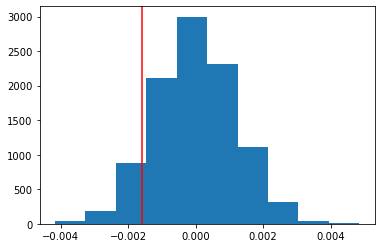

In [24]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');

#### p-value

The proportion of the **p_diffs** greater than the observed difference observed in **ab_data.csv**.

In [25]:
(p_diffs > obs_diff).mean()

0.9088

The p-value represents the probability of obtaining the observed statistic or one more extreme in favour of the alternative hypothesis when the null hypothesis is true. 

In this case, the p-value, 0.9, is much higher than the accepted alpha value of 0.05; therefore, we fail to reject the null hypothesis. Thus, it could be said that there is no difference between the new and old pages.

#### statsmodels.api calculation

Similar results can be achieved using statsmodels.api.

In [26]:
import statsmodels.api as sm

# Number of converted users with the old page (number of successes in the old page trial)
converted_new = df2.query("landing_page == 'new_page' & converted == 1").user_id.count()

# Number of converted users with the new page (number of successes in the new page trial)
converted_old = df2.query("landing_page == 'old_page' & converted == 1").user_id.count()

# Number of observations for new page 
n_new = df2.query("landing_page == 'new_page'").user_id.count()

# Number of observations for old page
n_old = df2.query("landing_page == 'old_page'").user_id.count()

`stats.proportions_ztest` is used  to compute the test statistic (zstat) and p-value.[Documentation here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) 

In [27]:
count = np.array([converted_new, converted_old])
nobs = np.array([n_new, n_old])
# This is a one-tail test where the alternative hypothesis is 'more than' or 'larger'
zstat, pval = sm.stats.proportions_ztest(count, nobs, alternative='larger')
zstat, pval

(-1.3109241984234394, 0.9050583127590245)

**Part ll - Conclusion** 

The above code computed the test statistic for the z-test and the p-value.

The z-statistic is the number representing how many standard deviations above or below the mean population a score derived from a z-test is. It is -1.31 standard deviations below the mean which is consistent with bootstrapping sampling results as indicated by the red line shown in the histogram above.

The difference between the two computed p-values is less than 0.004. Therefore, it could be stated that they agree with each other, and the findings are consistent with each other. Under both computations of the p-value, we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

The result achieved in the A/B test in Part II above can also be achieved by performing regression. 

Since each row is either a conversion or no conversion, **logistic regression** should be performed in this case.

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.

In [28]:
df2['intercept'] = 1

In [29]:
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

In [30]:
df2.drop(['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [31]:
# Fitting the model
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [32]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-02-17 19:15 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

#### Explanation of the p-value difference

In the statistical test in part ll **one-tail test** was performed: $p_{new}$ $\le$ $p_{old}$. This is because the hypothesis tested were as follows:

*Part ll hypotheses:*
$$H_0: p_{new} \le p_{old}$$
$$H_1: p_{new} > p_{old}$$

In the regression model, a **two-tail test** was performed. This is because the hypotheses tested in the logistic regression model are different and are as follows:

*Part lll hypotheses:*
$$H_0: \beta_{1} = 0$$
$$H_1: \beta_{1} \ne 0$$

*or*
$$H_0: p_{new} = p_{old}$$
$$H_1: p_{new} \ne p_{old}$$

The p-value for a two-sided test could be calculated like this: 
$$ p_{value} = 2*(1-p_{value})$$
$$ p_{value} = 2*(1-0.90)$$
$$ p_{value} = 2*(0.1)$$
$$ p_{value} = 0.2$$

$$ 0.1899 \approx 0.2$$

In this case, the p-value is also larger than the accepted alpha value of 0.025 (0.05/2). As can be seen from the calculations above the p-value from both part ll and part lll are roughly the same when the difference in the hypothesis and tests is considered.

#### Considering other factors that might influence whether or not an individual converts.

Since based on the p-value in both parts, it is clear that the page did not affect the conversion rates, it could be worthwhile to consider other factors that could influence the conversion. The aim will be to see if the introduced change affects the metric that was defined.

The addition could also help with confounding factors. When the webpages were randomly assigned to control and treatment groups, it is possible that there were confounding factors. These would refer to variables that influence the outcome of the experiment but were not evenly distributed across the control and treatment groups. Such variables could be added to control for their influence.

However, there is a disadvantage of adding additional terms to the regression model. For instance, one of such disadvantages would be collinearity. We want the predicting variables to correlate with the response variable and not with each other. To deal with this VIsF(variance inflation factors) could be used to remove the least important variable where variables are strongly related (VIF > 10).

Furthermore, it is possible that the explanatory variables could not be linearly related, and in this case, higher-order terms could be used.

#### Considering additional factor of location

Now along with testing if the conversion rate changes for different pages, an additional effect based on which country a user lives in will be considered. A new **countries.csv** dataset will be added.

In [33]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [34]:
df3 = df2.join(df_countries.set_index('user_id'), on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [35]:
# Unique countries of users
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [36]:
# Creating dummy variables for each country
df3[['US', 'CA', 'UK']] = pd.get_dummies(df3['country'])

In [37]:
# Removing one unnecessary row
df3.drop('CA', axis=1, inplace=True)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


Creating and fitting a new model with the new country variables

In [38]:
logit2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK']])
results2 = logit2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-02-17 19:15 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
UK           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

With the addition of the country variables, the p-value for the control and treatment groups remained roughly the same. The p-values for country variables are above the acceptable alpha and therefore not statistically significant. Thus, it could be said that the country of the user will not affect whether the user will convert or not.

Having looked at the individual factors of country and page on conversion, it is also possible to look at an interaction between page and country to see if there are significant effects on conversion.

In [39]:
df3['US_ab_page'] = df3['US']*df3['ab_page']
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
logit3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']])

results = logit3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-02-17 19:15 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
UK            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
US_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
UK_ab_page   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

As can be seen from the results above, all of the p-values are still larger than the alpha value. Therefore, it could be said that the interaction between page and country do not have significant effects on conversion.

<a id='conclusion'></a>
### Conclusion

The results from both parts ll and lll show that there is no statistically significant evidence to deduce that a new page will lead to a higher conversion rate. Hence, we fail to reject the null hypothesis in both of those instances. Having stated that, it is clear that e-commerce will not gain higher conversion rate with the new website, and therefore, the new website should not be implemented. 